In [ ]:
"""
Implementations of the algorithms (learning-based and the MVV)
for the adjacency list model in the experiments in the paper
"Triangle and Four Cycle Counting with Predictions in Graph Streams",
which are the simulative and deterministic space versions that simulate
the process of sampling the edges, for the purpose of faster running time
and easy to compare.

Course: Advanced Topics (Big Data Analytics)
Author: Rabist - https://www.linkedin.com/in/rabist
Teacher: Dr. Mostafa HaghirChehreghani - https://aut.ac.ir/cv/2350/Mostafa%20HaghirChehreghani
Univ: Amirkabir University of Technology
Semester: Spring 2022
"""


import random
import matplotlib.pyplot as plt
import numpy as np


class Pre:
    def __init__(self, file_train, file_test, pred_store=0.1):
        """Compute R_uv and the predictions for each edge
        based on a fixed random vertex arrival order.
        """
        self.file_train = file_train
        self.file_test = file_test
        self.pred_save = pred_store
        self.V_train, self.E_train, self.n_train, self.m_train = self.load(
            self.file_train)
        self.V_test, self.E_test, self.n_test, self.m_test = self.load(
            self.file_test)
        self.compute()

    def load(self, fp):
        """Load a graph dataset into memory.

        Args:
            fp (str): File path

        Returns:
            V: dict of vetices,
            E: set of edges,
            n: number of vertices,
            m: number of edges
        """
        V = {}
        E = set()
        n = 0
        m = 0

        with open(fp) as f:
            for l in f:

                # Fetch id of the nodes from the edge in current line.
                l = l.split()
                try:
                    u = int(l[0])
                    v = int(l[1])
                except:
                    continue

                # Ignore self loops in dirty graphs.
                if u == v:
                    continue

                # Ignore duplicate edges.
                if u > v:
                    u, v = v, u
                if (u, v) in E:
                    continue

                E.add((u, v))
                V.setdefault(u, []).append(v)
                V.setdefault(v, []).append(u)
                n = max(n, v)
                m += 1

        return V, E, n, m

    def compute(self):
        # Simulate fixed random vertex arrival order.
        order = np.zeros(self.n_test)
        for i in range(self.n_test):
            order[i] = i
        np.random.seed(2021)
        np.random.shuffle(order)

        pred = np.zeros(self.m_test)
        res = np.zeros(self.m_test)
        idx = 0

        for u, v in self.E_test:
            if order[u - 1] > order[v - 1]:
                u, v = v, u

            # Compute R_uv
            N_u = self.V_test.get(u, [])
            for i in range(len(N_u)):
                k = N_u[i]

                # Ignore the neighbors which violate the adjacency list model rule.
                if order[k - 1] <= order[u - 1] or order[k - 1] >= order[v - 1]:
                    continue

                if (v, k) in self.E_test or (k, v) in self.E_test:
                    res[idx] += 1

            # Compute N_uv
            N_u = self.V_train.get(u, [])
            for i in range(len(N_u)):
                k = N_u[i]
                if (v, k) in self.E_train or (k, v) in self.E_train:
                    pred[idx] += 1

            idx += 1

        # Store a small subset of predictions of train edges.
        thr = -np.sort(-pred)[int(self.pred_save * idx)]
        for i in range(idx):
            if pred[i] < thr:
                pred[i] = 0

        self.order = order
        self.pred = pred
        self.res = res


def take_sample(start, end, k):
    if start >= end:
        return np.zeros(end)
    if end - start <= k:
        choice = np.ones(end)
        return choice
    choice = np.zeros(end)
    ran = range(start, end)
    sample = random.sample(ran, k)
    for k in sample:
        choice[k] = 1
    return choice


def our_alg(res, pred, Z, num_exec=50, h_store=0.1, **kwargs):
    """
    Args:
        res (ndarray): R_uv
        pred (ndarray): N_uv
        Z (int): maximum number of edges allowed to store.
        num_exec (int): number of executions.
        h_store (int): proportion of heavy edges to store.

    Returns:
        float: relative error
    """
    sorted_pred = sorted(enumerate(pred), key=lambda x: x[1], reverse=True)
    idx = [i[0] for i in sorted_pred]

    T = np.sum(res)  # number of triangles
    m = len(pred)  # number of edges
    k = int(h_store * Z)  # number of heavy edges

    sampling_rate = min(1, (Z - k) / (m - k))
    T_est = 0

    for it in range(num_exec):
        sum_heavy = 0
        sum_light = 0
        choice = take_sample(k, m, Z - k)
        for i in range(m):
            if i < k:
                sum_heavy += res[idx[i]]
            else:
                if choice[i] == 0:
                    continue
                sum_light += res[idx[i]]
        T_est += abs(sum_heavy + sum_light / sampling_rate - T)
    T_est /= num_exec
    err = T_est / T
    return err


def our_alg_multi(res, pred, Z, num_exec=50, h_store=0.1, t_store=0.7, t_thr=5, **kwargs):
    """
    Args:
        res (ndarray): R_uv
        pred (ndarray): N_uv
        Z (int): maximum number of edges allowed to store.
        num_exec (int): number of executions.
        h_store (int): proportion of heavy edges to store.
        t_store (int): proportion of tiny edges to store.
        t_thr (int): tiny edges threshold.

    Returns:
        float: relative error
    """
    sorted_pred = sorted(enumerate(pred), key=lambda x: x[1], reverse=True)
    idx = [i[0] for i in sorted_pred]

    T = np.sum(res)  # number of triangles
    m = len(pred)  # number of edges
    k = int(h_store * Z)  # number of heavy edges
    r_store = 1 - (h_store + t_store)  # remaining store

    thr = 0
    for i in range(m):
        if pred[idx[i]] < t_thr:
            thr = i
            break

    sampling_rate1 = min(1, (r_store * Z) / (thr - k))
    sampling_rate2 = min(1, (t_store * Z) / (m - thr))
    T_est = 0

    for it in range(num_exec):
        sum_heavy = 0
        sum_light = 0
        sum_medium = 0
        medium_choice = take_sample(k, thr, int(r_store * Z))
        light_choice = take_sample(thr, m, int(t_store * Z))
        for i in range(m):
            if i < k:
                sum_heavy += res[idx[i]]
            elif i < thr:
                if medium_choice[i] == 0:
                    continue
                sum_medium += res[idx[i]]
            else:
                if light_choice[i] == 0:
                    continue
                sum_light += res[idx[i]]
        T_est += abs(sum_heavy + sum_medium / sampling_rate1 +
                     sum_light / sampling_rate2 - T)
    T_est /= num_exec
    err = T_est / T
    return err


def mvv(prep, Z, num_exec=50, h_thr=100, **kwargs):
    """
    Args:
        prep (Pre): preprocessed instance of the graph.
        Z (int): maximum number of edges allowed to store.
        num_exec (int): number of executions.
        h_thr (int): heavy edges threshold.

    Returns:
        float: relative error
    """
    res = prep.res
    order = prep.order
    V = prep.V_test
    E = prep.E_test

    T = np.sum(res)  # number of triangles
    m = len(res)  # number of edges

    sampling_rate = min(1, Z / m)
    T_est = 0

    for it in range(num_exec):
        choice = take_sample(0, m, Z)
        E_sample = set()

        i = 0
        for u, v in E:
            if choice[i] == 1:
                E_sample.add((u, v))
                E_sample.add((v, u))
            i += 1

        sum_heavy = 0
        sum_light = 0
        i = -1
        for u, v in E:
            i += 1
            if res[i] >= 50 / sampling_rate:
                if order[u - 1] >= order[v - 1]:
                    u, v = v, u
                N_u = V.get(u, [])
                est = 0
                for t in range(len(N_u)):
                    k = N_u[t]
                    if order[k - 1] <= order[u - 1] or order[k - 1] >= order[v - 1]:
                        continue
                    if (u, k) in E_sample and ((k, v) in E or (v, k) in E):
                        est += 1
                if est >= h_thr:
                    sum_heavy += est / sampling_rate
                    continue
            if choice[i] == 1:
                sum_light += res[i]
                continue
        T_est += abs(sum_heavy + sum_light / sampling_rate - T)
    T_est /= num_exec
    err = T_est / T
    return err


def eval(title, file_train, file_test, iter, **kwargs):
    prep = Pre(file_train=file_train, file_test=file_test)
    Z = list(iter)
    err1, err2, err3 = [], [], []

    for c, z in enumerate(Z):
        print(f"\rProgress: {int(c / len(Z) * 100)} %", end="")
        err1.append(our_alg(prep.res, prep.pred, Z=z, **kwargs))
        err2.append(our_alg_multi(prep.res, prep.pred, Z=z, **kwargs))
        err3.append(mvv(prep, Z=z, **kwargs))
    print("\rProgress: 100 %")

    plt.title(title)
    plt.plot(Z, err1, label="Our Alg", marker='o')
    plt.plot(Z, err2, label="Our Alg (multi-layer)", marker='o')
    plt.plot(Z, err3, label="MVV", marker='o')
    plt.xlabel("Space")
    plt.ylabel("Relative Error")
    plt.legend()
    plt.show()

In [ ]:
#!rm -r *

# Oregon
# https://snap.stanford.edu/data/Oregon-1.html
!wget https://snap.stanford.edu/data/oregon1_010331.txt.gz &> /dev/null 
!gunzip oregon1_010331.txt.gz
!wget https://snap.stanford.edu/data/oregon1_010421.txt.gz &> /dev/null
!gunzip oregon1_010421.txt.gz

# CAIDA
# https://snap.stanford.edu/data/as-Caida.html
!wget https://snap.stanford.edu/data/as-caida.tar.gz &> /dev/null 
!tar -xvf as-caida.tar.gz &> /dev/null

# Wikibooks
# http://networkrepository.com/edit-enwikibooks.php
!wget https://nrvis.com/download/data/dynamic/edit-enwikibooks.zip &> /dev/null 
!unzip edit-enwikibooks.zip &> /dev/null 
!split -l 582289 edit-enwikibooks.edges wiki_

Progress: 100 %


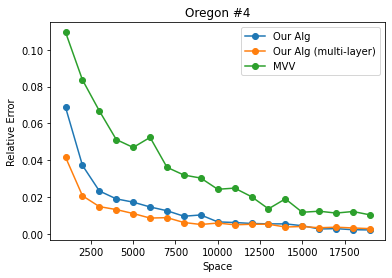

In [ ]:
eval("Oregon #4", 'oregon1_010331.txt', 'oregon1_010421.txt', range(1000, 20000, 1000))

Progress: 100 %


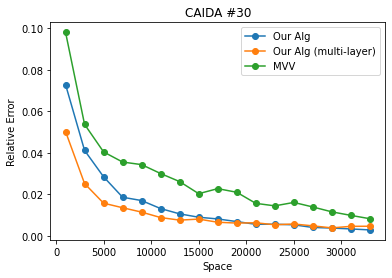

In [ ]:
eval("CAIDA #30", 'as-caida20040105.txt', 'as-caida20060206.txt', range(1000, 35000, 2000))

Progress: 100 %


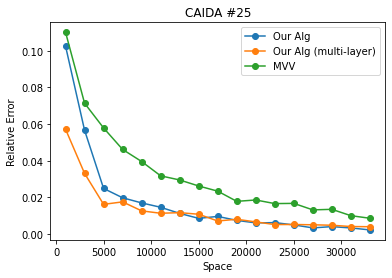

In [ ]:
eval("CAIDA #25", 'as-caida20040105.txt', 'as-caida20060102.txt', range(1000, 35000, 2000))

Progress: 100 %


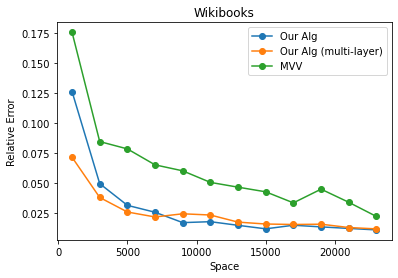

In [ ]:
eval("Wikibooks", 'wiki_ab', 'wiki_aa', range(1000, 25000, 2000))

In [ ]:
# Skitter
# https://snap.stanford.edu/data/as-Skitter.html
!wget https://snap.stanford.edu/data/as-skitter.txt.gz &> /dev/null 
!gunzip as-skitter.txt.gz &> /dev/null 
!split -l 5547652 as-skitter.txt as-skitter_

Progress: 100 %


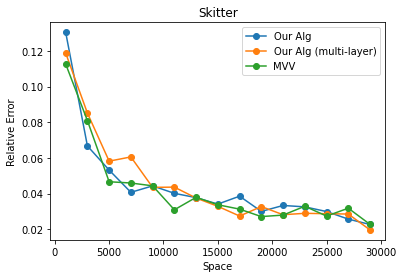

In [ ]:
eval("Skitter", 'as-skitter_aa', 'as-skitter_ab', range(1000, 30000, 2000))

In [ ]:
# Facebook
# https://snap.stanford.edu/data/ego-Facebook.html
!wget https://snap.stanford.edu/data/facebook_combined.txt.gz &> /dev/null 
!gunzip facebook_combined.txt.gz &> /dev/null 
!split -l 44117 facebook_combined.txt facebook_

Progress: 100 %


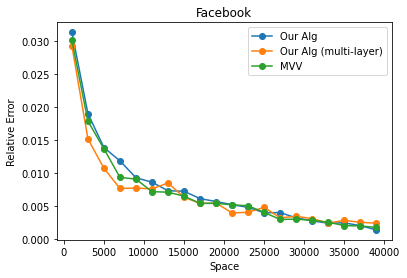

In [ ]:
eval("Facebook", 'facebook_aa', 'facebook_ab', range(1000, 40000, 2000))

In [ ]:
# Brightkite
# https://snap.stanford.edu/data/loc-Brightkite.html
!wget https://snap.stanford.edu/data/loc-brightkite_edges.txt.gz &> /dev/null 
!gunzip loc-brightkite_edges.txt.gz &> /dev/null 
!split -l 214078 loc-brightkite_edges.txt brightkite_

Progress: 100 %


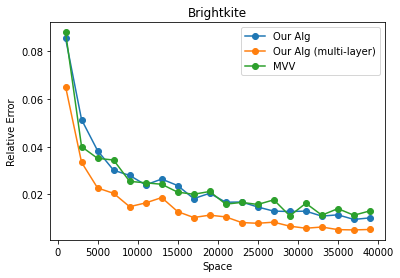

In [ ]:
eval("Brightkite", 'brightkite_aa', 'brightkite_ab', range(1000, 40000, 2000))

In [ ]:
# Astro Physics
# https://snap.stanford.edu/data/ca-AstroPh.html
!wget https://snap.stanford.edu/data/ca-AstroPh.txt.gz &> /dev/null 
!gunzip ca-AstroPh.txt.gz &> /dev/null 
!split -l 198082 ca-AstroPh.txt AstroPh_

Progress: 100 %


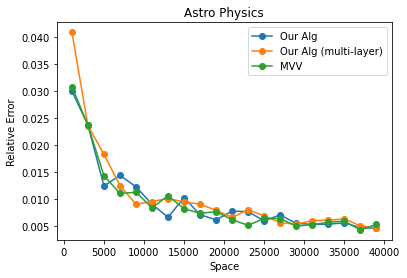

In [ ]:
eval("Astro Physics", 'AstroPh_aa', 'AstroPh_ab', range(1000, 40000, 2000))

In [ ]:
# Enron
# https://snap.stanford.edu/data/email-Enron.html
!wget https://snap.stanford.edu/data/email-Enron.txt.gz &> /dev/null 
!gunzip email-Enron.txt.gz &> /dev/null 
!split -l 183833 email-Enron.txt Enron_

Progress: 100 %


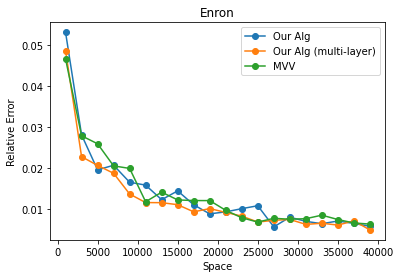

In [ ]:
eval("Enron", 'Enron_aa', 'Enron_ab', range(1000, 40000, 2000))

In [ ]:
# Amazon
# https://snap.stanford.edu/data/com-Amazon.html
!wget https://snap.stanford.edu/data/bigdata/communities/com-amazon.ungraph.txt.gz &> /dev/null 
!gunzip com-amazon.ungraph.txt.gz &> /dev/null 
!split -l 462938 com-amazon.ungraph.txt amazon_

Progress: 100 %


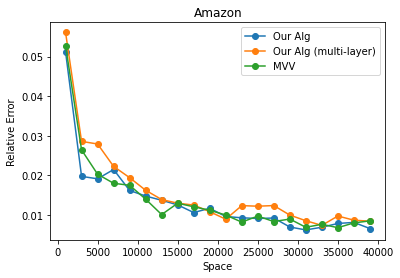

In [ ]:
eval("Amazon", 'amazon_aa', 'amazon_ab', range(1000, 40000, 2000))